In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error

In [28]:
df = pd.read_csv('petr4_treinamento.csv')

In [29]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [30]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1240,2017-12-25,15.75,15.750000,15.75,15.750000,15.718563,0.0
1241,2017-12-26,15.75,15.990000,15.69,15.970000,15.938125,22173100.0
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [31]:
df.shape

(1245, 7)

In [32]:
df = df.dropna()

In [33]:
train_df = df.iloc[:, 1:2].values

In [34]:
train_df

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [35]:
normalizer = MinMaxScaler(feature_range=(0, 1))

train_df_normalized = normalizer.fit_transform(train_df)

In [36]:
train_df_normalized

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [37]:
x = []
y = []

for i in range(90, df.shape[0]):
    x.append(train_df_normalized[i-90:i, 0])
    y.append(train_df_normalized[i, 0])

x, y = np.array(x), np.array(y)

In [38]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [39]:
dataset = torch.utils.data.TensorDataset(x, y)

In [40]:
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=100)
        self.lstm2 = nn.LSTM(100, 50)
        self.lstm3 = nn.LSTM(50, 50, dropout=0.3, num_layers=2)

        self.dropout = nn.Dropout(0.3)

        self.linear = nn.Linear(in_features=50, out_features=1)

    def forward(self, X):
        X = X.permute(1, 0).unsqueeze(2)

        X, _ = self.lstm1(X)

        X = self.dropout(X)

        X, _ = self.lstm2(X)

        X = self.dropout(X)

        X, _ = self.lstm3(X)

        X = self.dropout(X)

        X = X[-1]
        X = self.dropout(X)

        X = self.linear(X)

        return X

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
regressor = regressor_LSTM().to(device)

In [44]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(regressor.parameters(), lr=0.001)

In [45]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = regressor(inputs)
      outputs = outputs.flatten()

      loss = criterion(outputs, labels)
      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten())

      running_mae += mae

      print(f'Epoch {epoch+1}, Loss: {running_loss/len(loader)}, MAE: {running_mae/len(loader)}')

    running_loss /= len(loader)
    running_mae /= len(loader)

    print(f'Epoch {epoch+1}, Loss: {running_loss}, MAE: {running_mae}')


Epoch 1, Loss: 0.007867892583211264, MAE: 0.013936751418643527
Epoch 1, Loss: 0.00957893735418717, MAE: 0.01951188262965944
Epoch 1, Loss: 0.04592066413412491, MAE: 0.04933303346236547
Epoch 1, Loss: 0.049168621810774006, MAE: 0.05739285879664951
Epoch 1, Loss: 0.05121072640435563, MAE: 0.0638154505027665
Epoch 1, Loss: 0.052511065267026424, MAE: 0.0689713168475363
Epoch 1, Loss: 0.05381967510200209, MAE: 0.07411828140417735
Epoch 1, Loss: 0.05541874240669939, MAE: 0.07971049845218658
Epoch 1, Loss: 0.05694709076649613, MAE: 0.08512585279014376
Epoch 1, Loss: 0.058586978250079684, MAE: 0.09066776475972599
Epoch 1, Loss: 0.06007287527124087, MAE: 0.0962115584148301
Epoch 1, Loss: 0.0623889762080378, MAE: 0.10290135857131746
Epoch 1, Loss: 0.06408169141246213, MAE: 0.10844114091661242
Epoch 1, Loss: 0.06554987364345127, MAE: 0.11419372301962641
Epoch 1, Loss: 0.06640583488883244, MAE: 0.1181112705833382
Epoch 1, Loss: 0.06776101385346717, MAE: 0.12313392841153675
Epoch 1, Loss: 0.0692630

In [47]:
test_df = pd.read_csv('petr4_teste.csv')

In [48]:
test_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [49]:
real_price_test = test_df.iloc[:, 1:2].values

In [50]:
real_price_test

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [51]:
all_df = pd.concat((df['Open'], test_df['Open']), axis=0)

In [52]:
all_df

0     19.990000
1     19.809999
2     20.330000
3     20.480000
4     20.110001
        ...    
17    19.340000
18    19.620001
19    19.670000
20    19.770000
21    19.740000
Name: Open, Length: 1264, dtype: float64

In [59]:
entry = all_df[len(all_df) - len(test_df) - 90:].values

In [60]:
entry

array([13.93    , 13.76    , 13.79    , 13.53    , 13.85    , 13.96    ,
       14.57    , 14.65    , 15.02    , 15.1     , 14.88    , 14.98    ,
       14.94    , 15.03    , 15.07    , 15.02    , 15.1     , 15.25    ,
       15.85    , 15.6     , 15.79    , 15.86    , 15.7     , 15.37    ,
       15.5     , 15.19    , 15.6     , 15.9     , 15.88    , 15.66    ,
       15.61    , 16.129999, 16.17    , 16.08    , 16.23    , 16.16    ,
       16.139999, 16.219999, 16.      , 16.190001, 16.290001, 16.290001,
       16.530001, 16.780001, 16.77    , 16.969999, 16.9     , 16.99    ,
       16.9     , 16.959999, 17.049999, 17.309999, 16.690001, 16.889999,
       16.709999, 16.690001, 16.639999, 15.35    , 15.62    , 15.92    ,
       16.02    , 16.15    , 16.09    , 15.98    , 16.25    , 16.01    ,
       15.93    , 15.87    , 15.3     , 15.34    , 15.65    , 15.5     ,
       15.22    , 15.3     , 15.51    , 15.48    , 15.36    , 15.65    ,
       15.1     , 15.05    , 15.16    , 15.18    , 

In [61]:
entry = entry.reshape(-1, 1)

In [62]:
entry

array([[13.93    ],
       [13.76    ],
       [13.79    ],
       [13.53    ],
       [13.85    ],
       [13.96    ],
       [14.57    ],
       [14.65    ],
       [15.02    ],
       [15.1     ],
       [14.88    ],
       [14.98    ],
       [14.94    ],
       [15.03    ],
       [15.07    ],
       [15.02    ],
       [15.1     ],
       [15.25    ],
       [15.85    ],
       [15.6     ],
       [15.79    ],
       [15.86    ],
       [15.7     ],
       [15.37    ],
       [15.5     ],
       [15.19    ],
       [15.6     ],
       [15.9     ],
       [15.88    ],
       [15.66    ],
       [15.61    ],
       [16.129999],
       [16.17    ],
       [16.08    ],
       [16.23    ],
       [16.16    ],
       [16.139999],
       [16.219999],
       [16.      ],
       [16.190001],
       [16.290001],
       [16.290001],
       [16.530001],
       [16.780001],
       [16.77    ],
       [16.969999],
       [16.9     ],
       [16.99    ],
       [16.9     ],
       [16.959999],


In [63]:
entry = normalizer.transform(entry)

In [64]:
x_test = []

for i in range(90, 112):
    x_test.append(entry[i-90:i, 0])

x_test = np.array(x_test)

In [65]:
x_test = torch.tensor(x_test, device = device, dtype=torch.float32)

In [66]:
regressor.eval()

regressor_LSTM(
  (lstm1): LSTM(1, 100)
  (lstm2): LSTM(100, 50)
  (lstm3): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [67]:
forecast = regressor.forward(x_test)

In [68]:
forecast

tensor([[0.5417],
        [0.5439],
        [0.5542],
        [0.5666],
        [0.5668],
        [0.5664],
        [0.5758],
        [0.5757],
        [0.5728],
        [0.5770],
        [0.5878],
        [0.5916],
        [0.6091],
        [0.6282],
        [0.6302],
        [0.6269],
        [0.6305],
        [0.6327],
        [0.6619],
        [0.6787],
        [0.6809],
        [0.6831]], grad_fn=<AddmmBackward0>)

In [69]:
forecast.shape

torch.Size([22, 1])

In [70]:
forecast = forecast.detach().cpu().numpy()

In [72]:
forecast = forecast.reshape(-1, 1)

In [73]:
forecast = normalizer.inverse_transform(forecast)

In [75]:
forecast.mean()

16.66144

In [76]:
real_price_test.mean()

17.87454563636364

In [78]:
forecast[0]

array([15.380193], dtype=float32)

In [79]:
real_price_test[0]

array([16.190001])

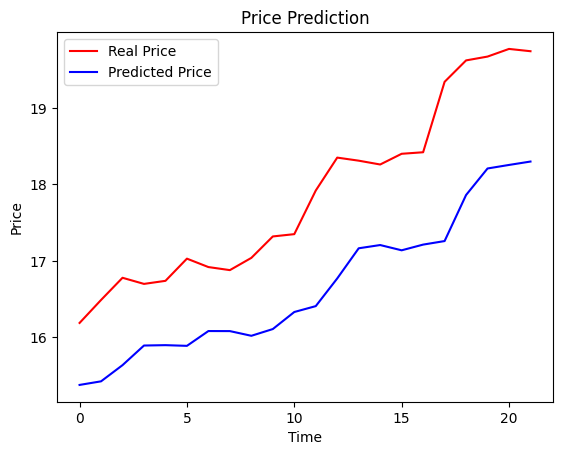

In [77]:
plt.plot(real_price_test, color='red', label='Real Price')
plt.plot(forecast, color='blue', label='Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

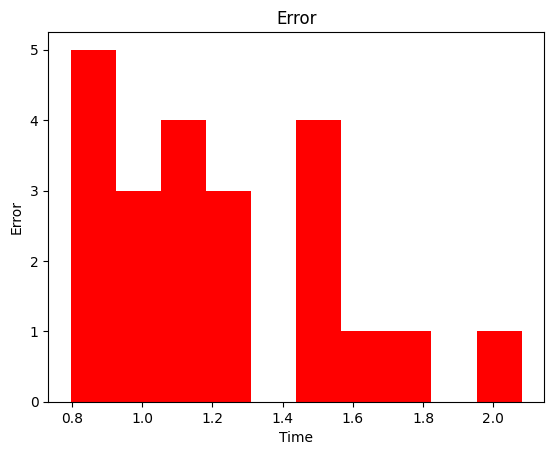

In [81]:
eval = real_price_test - forecast

plt.hist(eval, color='red')
plt.title('Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()